# Cluster PC examples

This notebook supports Chapter 4.3.1 Examples of C-PC in https://sharelatex.tum.de/read/npjkjggtqffh . It shows how to use the clustercausal package to construct a DAG, data and a corresponding C-DAG and then run the PC and C-PC algorithm to compare their outputs. 

To not get confused, I recommend running the notebook only once. When one wants to re-run code, it is recommended to run all cells from above or run from the beginning of one example, as otherwise code from later examples might be loaded from memory and lead to wrong results.

In [1]:
#importing libraries and dependencies
%load_ext autoreload
%autoreload 2
import numpy as np
from causallearn.search.ConstraintBased.PC import pc
from clustercausal.experiments.Simulator import Simulator
from clustercausal.experiments.Evaluator import Evaluator
from clustercausal.algorithms.ClusterPC import ClusterPC as ClusterPC
from clustercausal.clusterdag.ClusterDAG import ClusterDAG
from clustercausal.utils.Utils import *

c:\Users\JanMarco\MLProjects\Masterthesis\masterthesis\mthesis\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Detecting 1 CUDA device(s).
2023-11-25 15:01:25,444 - c:\Users\JanMarco\MLProjects\Masterthesis\masterthesis\mthesis\lib\site-packages\rpy2\situation.py[line:41] - INFO: cffi mode is CFFI_MODE.ANY
2023-11-25 15:01:25,451 - c:\Users\JanMarco\MLProjects\Masterthesis\masterthesis\mthesis\lib\site-packages\rpy2\situation.py[line:218] - INFO: R home found: C:\Program Files\R\R-4.3.1
2023-11-25 15:01:25,475 - c:\Users\JanMarco\MLProjects\Masterthesis\masterthesis\mthesis\lib\site-packages\rpy2\rinterface_lib\embedded.py[line:20] - INFO: Default options to initialize R: rpy2, --quiet, --no-save


Nodes will start with $X_0$, as that makes it easier to understand the corresponding python code. 

## Example 1: 3-node graph with 2 clusters
This example shows how C-PC can orient additional edges for the graph $X_0 \rightarrow X_1 \rightarrow X_2$, with clusters $C_1 = \{X_0\}$ and $C_2 = \{X_1, X_2\}$.

In [2]:
# Construct DAG as CausalGraph object and get adjacency matrix with make_graph() function from Utils.py
node_names = ['X0', 'X1', 'X2']
parent_dict = {'X0': [], 'X1': ['X0'], 'X2': ['X1']}
cg, W = make_graph(node_names, parent_dict)

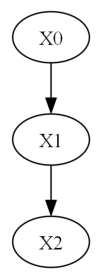

In [3]:
# Draw DAG
cg.draw_pydot_graph()

Next construct ClusterDAG object with C-DAG $C_1 \rightarrow C_2$

In [4]:
cluster_mapping = {'C1': ['X0'], 'C2': ['X1', 'X2']}
cluster_edges = [('C1', 'C2')]
cluster_dag = ClusterDAG(cluster_mapping=cluster_mapping, cluster_edges=cluster_edges)
print(f'Cluster mapping: {cluster_dag.cluster_mapping} \n Cluster edges: {cluster_dag.cluster_edges}')

Cluster mapping: {'C1': ['X0'], 'C2': ['X1', 'X2']} 
 Cluster edges: [('C1', 'C2')]


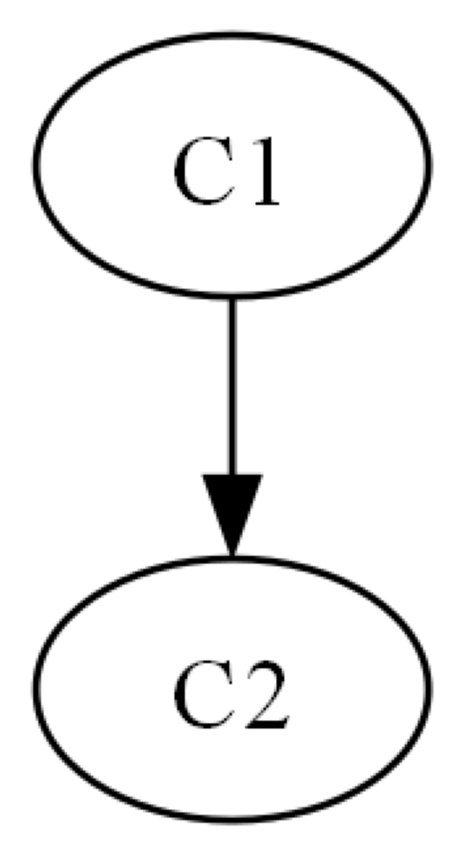

In [5]:
# Draw C-DAG
cluster_dag.cluster_graph.draw_pydot_graph()

Next the causal graph associated to the C-DAG has to be initalized, edges have to be pruned and oriented. cluster_dag.cdag_to_mpdag handles this and then cluster_dag.cg becomes available. This object is the supergraph of all DAGs compatible with the C-DAG

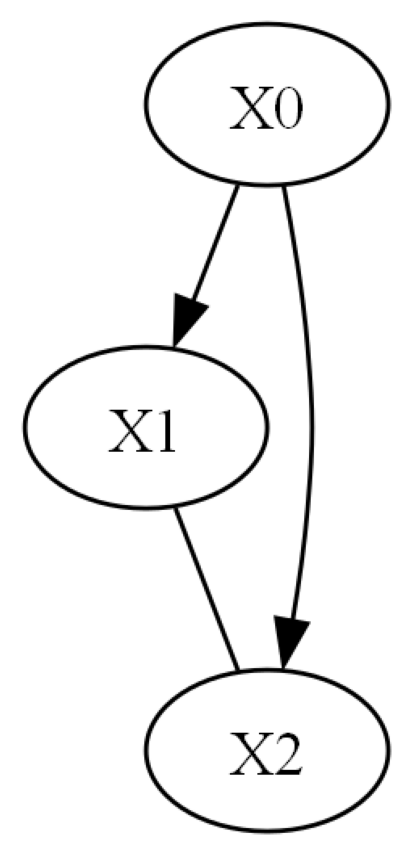

In [6]:
cluster_dag.cdag_to_mpdag()
cluster_dag.cg.draw_pydot_graph()

Lastly, the true dag is added to cluster_dag. 

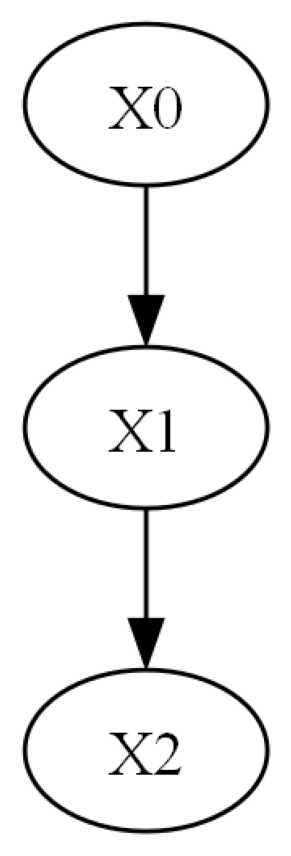

In [7]:
cluster_dag.true_dag = cg
cluster_dag.true_dag.draw_pydot_graph()

Next generate gaussian data for C-PC and PC with Utils.py gaussian_data(). This is an additive noise model with weights 1.0. 

In [8]:
data = gaussian_data(W = W, sample_size = 1000, seed = 42)
data.shape

(1000, 3)

To run PC use the causallearn package. 

In [9]:
pc_est_graph = pc(data, alpha = 0.1, verbose=False, node_names=node_names)

Depth=1, working on node 2: 100%|██████████| 3/3 [00:00<00:00, 600.27it/s] 


pc_est_graph is a CausalGraph object and can be drawn

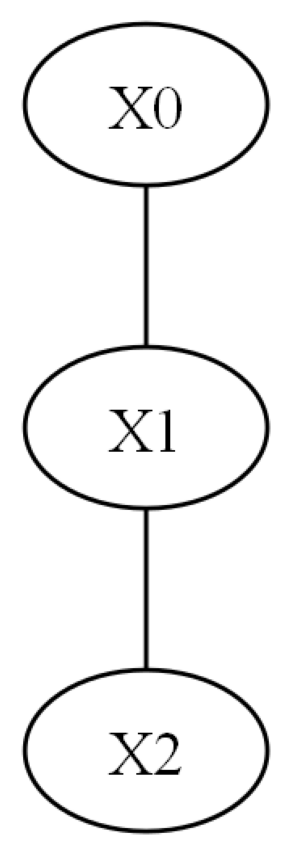

In [10]:
pc_est_graph.draw_pydot_graph()

To run C-PC initialize a cluster_pc object and use the cluster_pc.run() function. 

In [11]:
cluster_pc = ClusterPC(cdag = cluster_dag, data = data, alpha = 0.1, 
                  indep_test = "fisherz", \
                  verbose = False, show_progress=True)
cluster_pc_est_graph = cluster_pc.run()

C2 phase, Depth=1, working on node 2: 100%|██████████| 2/2 [00:00<00:00, 500.27it/s, duration: 0.01sec]

Duration of algorithm was 0.02sec


cluster_est_graph is a CausalGraph object and can be drawn. 

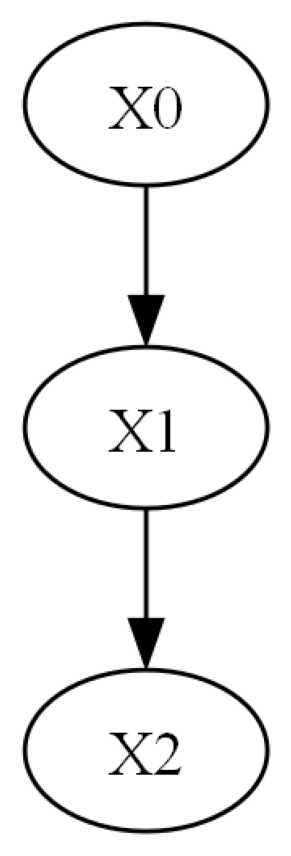

In [12]:
cluster_pc_est_graph.draw_pydot_graph()

Due to the edges from the cluster, C-PC can orient the edge $X_1 \rightarrow X_2$ and then due to orientation rules $X_2 \rightarrow X_3$.

For more evaluations one can call the Evaluator class from clustercausal. The error comes due to precision being nan as there are no true and false positives. SID can be calculated but takes around 5 seconds, can be turned off by changing to get_causallearn_metrics(sid = False). 

The adjacency confusion counts how many edges are correct. Arrow confusion counts how many arrows are correct. SHD is the structural hamming distance and SID is the structural intervention distance.

In [13]:
# Evaluator works on the GeneralGraph object of a CausalGraph object, which is cg.G, cluster_dag.true_dag.G or pc_est_graph.G
eval_pc = Evaluator(truth = cluster_dag.true_dag.G, est = pc_est_graph.G)
adjacency_confusion, arrow_confusion, shd, sid = eval_pc.get_causallearn_metrics(sid = True)
print("Adjacency confusion: ", adjacency_confusion)
print("Arrow confusion: ", arrow_confusion)
print("SHD: ", shd)
print("SID: ",  sid)

invalid value encountered in double_scalars
invalid value encountered in double_scalars


Adjacency confusion:  {'true_positive': 2, 'false_positive': 0, 'false_negative': 0, 'true_negative': 1, 'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0}
Arrow confusion:  {'true_positive': 0.0, 'false_positive': 0.0, 'false_negative': 2.0, 'true_negative': 7.0, 'precision': nan, 'recall': 0.0, 'f1_score': nan, 'true_positive_ce': 0.0, 'false_positive_ce': 0.0, 'false_negative_ce': 2.0, 'true_negative_ce': 7.0, 'precision_ce': nan, 'recall_ce': 0.0, 'f1_score_ce': nan}
SHD:  0
SID:  {'sid_lower': 0, 'sid_upper': 6}


In [14]:
eval_cluster_pc = Evaluator(truth = cluster_dag.true_dag.G, est = cluster_pc_est_graph.G)
adjacency_confusion, arrow_confusion, shd, sid = eval_cluster_pc.get_causallearn_metrics(sid = True)
print("Adjacency confusion: ", adjacency_confusion)
print("Arrow confusion: ", arrow_confusion)
print("SHD: ", shd)
print("SID: ",  sid)

Adjacency confusion:  {'true_positive': 2, 'false_positive': 0, 'false_negative': 0, 'true_negative': 1, 'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0}
Arrow confusion:  {'true_positive': 2.0, 'false_positive': 0.0, 'false_negative': 0.0, 'true_negative': 7.0, 'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0, 'true_positive_ce': 2.0, 'false_positive_ce': 0.0, 'false_negative_ce': 0.0, 'true_negative_ce': 7.0, 'precision_ce': 1.0, 'recall_ce': 1.0, 'f1_score_ce': 1.0}
SHD:  0
SID:  {'sid_lower': 0, 'sid_upper': 0}


While both algorithms recover the correct skeleton, C-PC also can recover the correct edge orientations and therefore has better arrow precision and recall as well as lower SID upper bound. 

## Example 2: 6-node graph with 3 clusters
This example shows how C-PC can orient additional edges for a bigger graph with 6 nodes total. 

In [15]:
# Construct DAG as CausalGraph object and get adjacency matrix with make_graph() function from Utils.py
node_names = ['X0', 'X1', 'X2', 'X3', 'X4', 'X5']
parent_dict = {'X0': [], 'X1': ['X0'], 'X2': ['X1'], 'X3': ['X2'], 'X4': ['X2'], 'X5': ['X4']}
cg, W = make_graph(node_names, parent_dict)

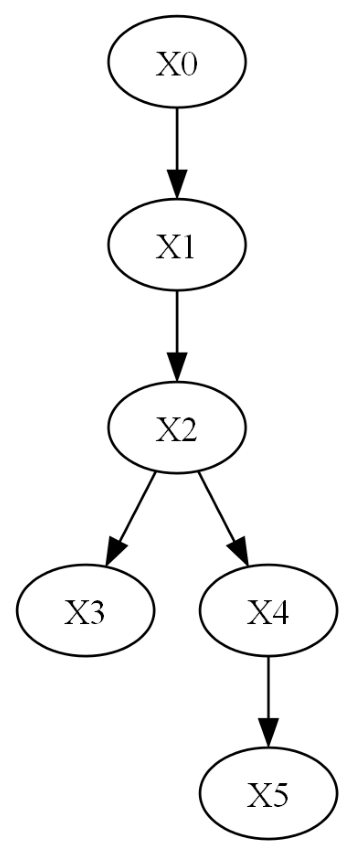

In [16]:
# Draw DAG
cg.draw_pydot_graph()

Next construct ClusterDAG object with C-DAG $C_1 \rightarrow C_2 \rightarrow C_3$. It is best practice to have the node_names, the order of the data matrix and the concatenated cluster_mapping lists in the same order. 

I.e. cluster_mapping = {'C3': ['X4', 'X5'], 'C2': ['X2', 'X3'], 'C1': ['X0', 'X1']} or cluster_mapping = {'C1': ['X1', 'X0'], 'C2': ['X3', 'X2'], 'C3' : ['X5', 'X4']} should be avoided as that makes the algorithms connect wrong columns to the wrong variables. 

In [17]:
cluster_mapping = {'C1': ['X0', 'X1'], 'C2': ['X2', 'X3'], 'C3': ['X4', 'X5']}
cluster_edges = [('C1', 'C2'), ('C2', 'C3')]
cluster_dag = ClusterDAG(cluster_mapping=cluster_mapping, cluster_edges=cluster_edges)
print(f'Cluster mapping: {cluster_dag.cluster_mapping} \n Cluster edges: {cluster_dag.cluster_edges}')

Cluster mapping: {'C1': ['X0', 'X1'], 'C2': ['X2', 'X3'], 'C3': ['X4', 'X5']} 
 Cluster edges: [('C1', 'C2'), ('C2', 'C3')]


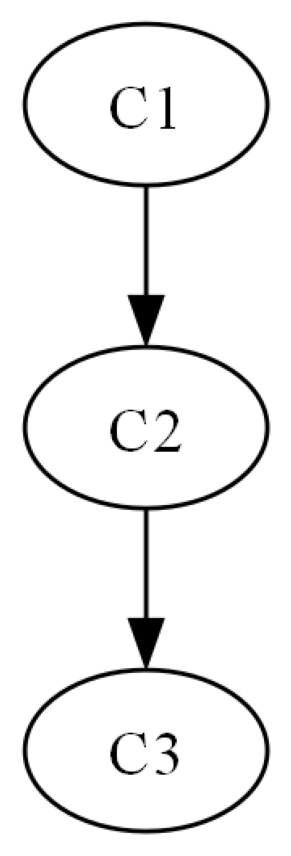

In [18]:
# Draw C-DAG
cluster_dag.cluster_graph.draw_pydot_graph()

Next the causal graph associated to the C-DAG has to be initalized, edges have to be pruned and oriented. cluster_dag.cdag_to_mpdag handles this and then cluster_dag.cg becomes available. This object is the supergraph of all DAGs compatible with the C-DAG. It has directed edges between members of $C_1$,$C_2$ and $C_2,C_3$ and undirected edges within clusters. 

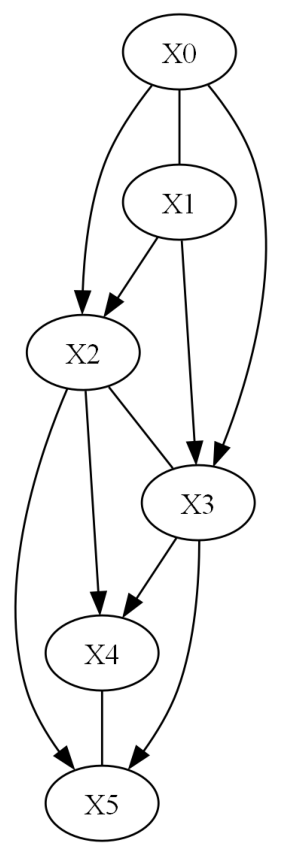

In [19]:
cluster_dag.cdag_to_mpdag()
cluster_dag.cg.draw_pydot_graph()

Lastly, the true dag is added to cluster_dag. 

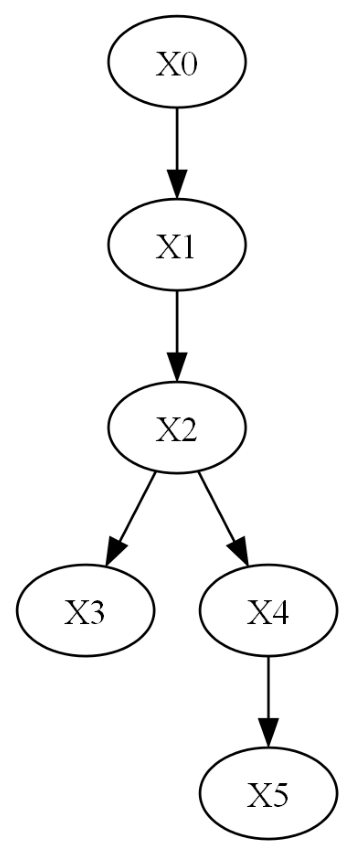

In [20]:
cluster_dag.true_dag = cg
cluster_dag.true_dag.draw_pydot_graph()

Next generate gaussian data for C-PC and PC with Utils.py gaussian_data(). This is an additive noise model with weights 1.0. 

In [21]:
data = gaussian_data(W = W, sample_size = 1000, seed = 300)
data.shape

(1000, 6)

To run PC use the causallearn package. 

In [22]:
pc_est_graph = pc(data, alpha = 0.1, verbose=False, node_names=node_names)

Depth=2, working on node 5: 100%|██████████| 6/6 [00:00<00:00, 1000.71it/s]


pc_est_graph is a CausalGraph object and can be drawn

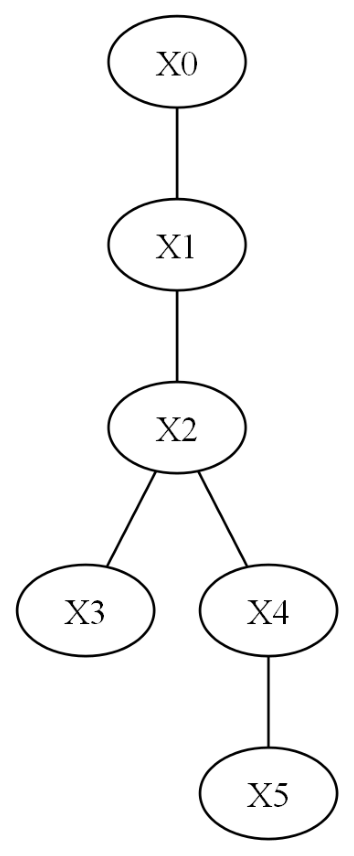

In [23]:
pc_est_graph.draw_pydot_graph()

To run C-PC initialize a cluster_pc object and use the cluster_pc.run() function. 

In [24]:
cluster_pc = ClusterPC(cdag = cluster_dag, data = data, alpha = 0.1, 
                  indep_test = "fisherz", \
                  verbose = False, show_progress=True)
cluster_pc_est_graph = cluster_pc.run()

C3 phase, Depth=2, working on node 5: 100%|██████████| 2/2 [00:00<00:00, 400.28it/s, duration: 0.02sec]

Duration of algorithm was 0.05sec


cluster_est_graph is a CausalGraph object and can be drawn. 

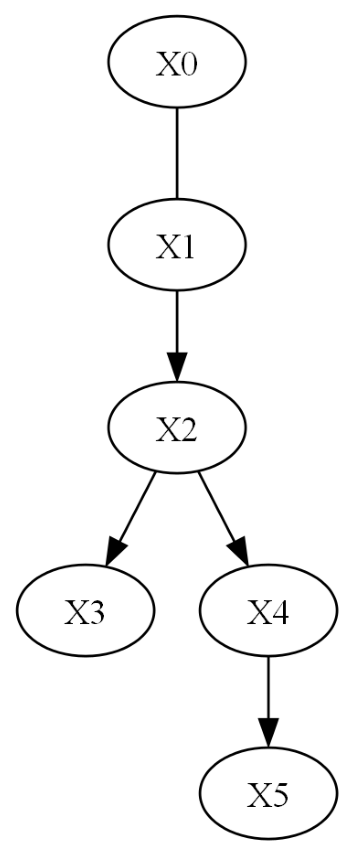

In [25]:
cluster_pc_est_graph.draw_pydot_graph()

Due to the edges from the cluster, C-PC can orient almost all edges. This is a big improvement compared to PC as it allows much better causal effect estimation. This is also reflected in the upper SID bound being 6 for C-PC instead of 24 for PC. 

For more evaluations one can call the Evaluator class from clustercausal. 
The adjacency confusion counts how many edges are correct. Arrow confusion counts how many arrows are correct. SHD is the structural hamming distance and SID is the structural intervention distance.
The error 'invalid value encountered in scalar divide' comes due to arrow_precision being nan. SID can be calculated but takes around 5 seconds, can be turned off by changing to get_causallearn_metrics(sid = False). 


In [26]:
# Evaluator works on the GeneralGraph object of a CausalGraph object, which is cg.G, cluster_dag.true_dag.G or pc_est_graph.G
eval_pc = Evaluator(truth = cluster_dag.true_dag.G, est = pc_est_graph.G)
adjacency_confusion, arrow_confusion, shd, sid = eval_pc.get_causallearn_metrics(sid = True)
print("Adjacency confusion: ", adjacency_confusion)
print("Arrow confusion: ", arrow_confusion)
print("SHD: ", shd)
print("SID: ",  sid)

invalid value encountered in double_scalars
invalid value encountered in double_scalars


Adjacency confusion:  {'true_positive': 5, 'false_positive': 0, 'false_negative': 0, 'true_negative': 10, 'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0}
Arrow confusion:  {'true_positive': 0.0, 'false_positive': 0.0, 'false_negative': 5.0, 'true_negative': 31.0, 'precision': nan, 'recall': 0.0, 'f1_score': nan, 'true_positive_ce': 0.0, 'false_positive_ce': 0.0, 'false_negative_ce': 5.0, 'true_negative_ce': 31.0, 'precision_ce': nan, 'recall_ce': 0.0, 'f1_score_ce': nan}
SHD:  0
SID:  {'sid_lower': 0, 'sid_upper': 24}


In [27]:
eval_cluster_pc = Evaluator(truth = cluster_dag.true_dag.G, est = cluster_pc_est_graph.G)
adjacency_confusion, arrow_confusion, shd, sid = eval_cluster_pc.get_causallearn_metrics(sid = True)
print("Adjacency confusion: ", adjacency_confusion)
print("Arrow confusion: ", arrow_confusion)
print("SHD: ", shd)
print("SID: ",  sid)

Adjacency confusion:  {'true_positive': 5, 'false_positive': 0, 'false_negative': 0, 'true_negative': 10, 'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0}
Arrow confusion:  {'true_positive': 4.0, 'false_positive': 0.0, 'false_negative': 1.0, 'true_negative': 31.0, 'precision': 1.0, 'recall': 0.8, 'f1_score': 0.888888888888889, 'true_positive_ce': 4.0, 'false_positive_ce': 0.0, 'false_negative_ce': 1.0, 'true_negative_ce': 31.0, 'precision_ce': 1.0, 'recall_ce': 0.8, 'f1_score_ce': 0.888888888888889}
SHD:  0
SID:  {'sid_lower': 0, 'sid_upper': 6}


Again both algorithms recover the correct skeleton, C-PC also can recover the correct edge orientations and therefore has much better arrow precision and recall as well as lower SID upper bound. 

One can also compare the numer of CI tests the two methods perform comparing the 3 cluster C-PC with a 1 cluster C-PC, which is equivalent to PC. 

In [28]:
no_clust_cluster_mapping = {'C1': ['X0', 'X1', 'X2', 'X3', 'X4', 'X5']}
no_clust_cluster_edges = []
no_clust_cluster_dag = ClusterDAG(cluster_mapping=no_clust_cluster_mapping, cluster_edges=no_clust_cluster_edges)

In [29]:
no_clust_cpc = ClusterPC(cdag = no_clust_cluster_dag, data = data, alpha = 0.1, \
                    indep_test = "fisherz", verbose = False, show_progress=True, cluster_only=True)
no_clust_cpc_est_graph = no_clust_cpc.run()

C1 phase, Depth=2, working on node 5: 100%|██████████| 6/6 [00:00<00:00, 667.07it/s, duration: 0.05sec]

Duration of algorithm was 0.06sec


In [30]:
print(f' Without clustering: {no_clust_cpc.no_of_indep_tests_performed} CI tests, \n with 3 clusters: {cluster_pc.no_of_indep_tests_performed} CI tests')

 Without clustering: 153 CI tests, 
 with 3 clusters: 38 CI tests


## Example 3: 7-node graph with 3 clusters
This example shows how C-PC and PC differ when CI tests make errors. The graph has 7 nodes and 3 clusters in a v-structure. 

In [31]:
# Construct DAG as CausalGraph object and get adjacency matrix with make_graph() function from Utils.py
node_names = ['X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6']
parent_dict = {'X0': [], 'X1': [], 'X2': [], 'X3': ['X2'], 'X4': ['X2', 'X3'], 'X5' : ['X0', 'X1', 'X4'], 'X6': ['X3', 'X4']}
cg, W = make_graph(node_names, parent_dict)

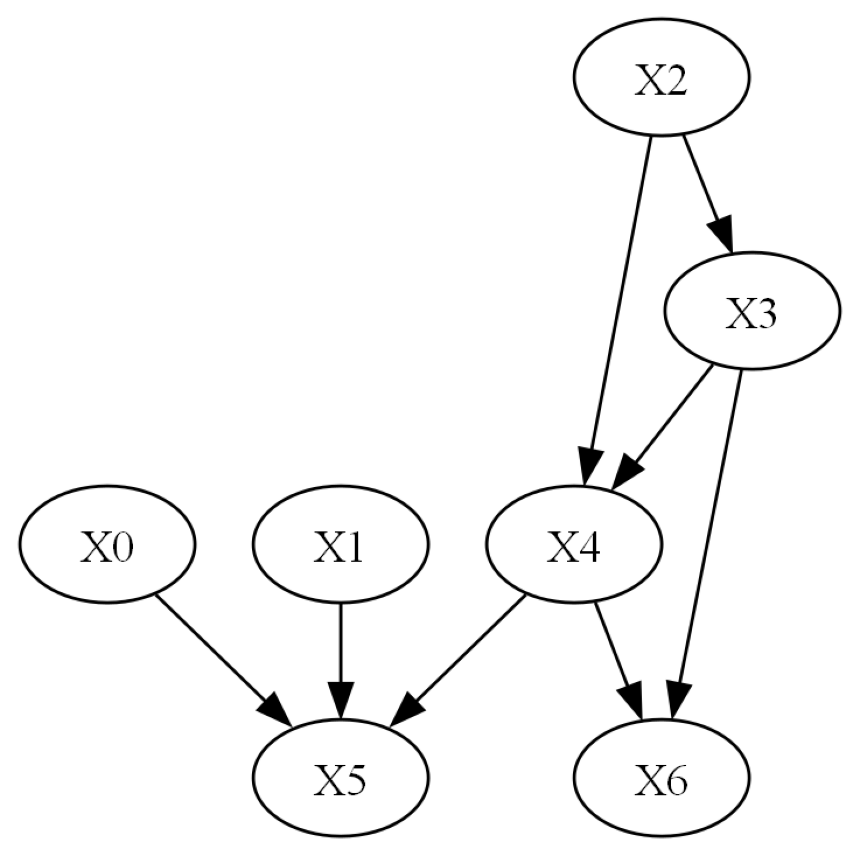

In [32]:
# Draw DAG
cg.draw_pydot_graph()

Next construct ClusterDAG object with C-DAG $C_1 \rightarrow C_3 \leftarrow C_2$. 

In [33]:
cluster_mapping = {'C1': ['X0', 'X1'], 'C2': ['X2', 'X3'] ,'C3': ['X4', 'X5', 'X6']}
cluster_edges = [('C1', 'C3'), ('C2', 'C3')]
cluster_dag = ClusterDAG(cluster_mapping=cluster_mapping, cluster_edges=cluster_edges)
print(f'Cluster mapping: {cluster_dag.cluster_mapping} \n Cluster edges: {cluster_dag.cluster_edges}')

Cluster mapping: {'C1': ['X0', 'X1'], 'C2': ['X2', 'X3'], 'C3': ['X4', 'X5', 'X6']} 
 Cluster edges: [('C1', 'C3'), ('C2', 'C3')]


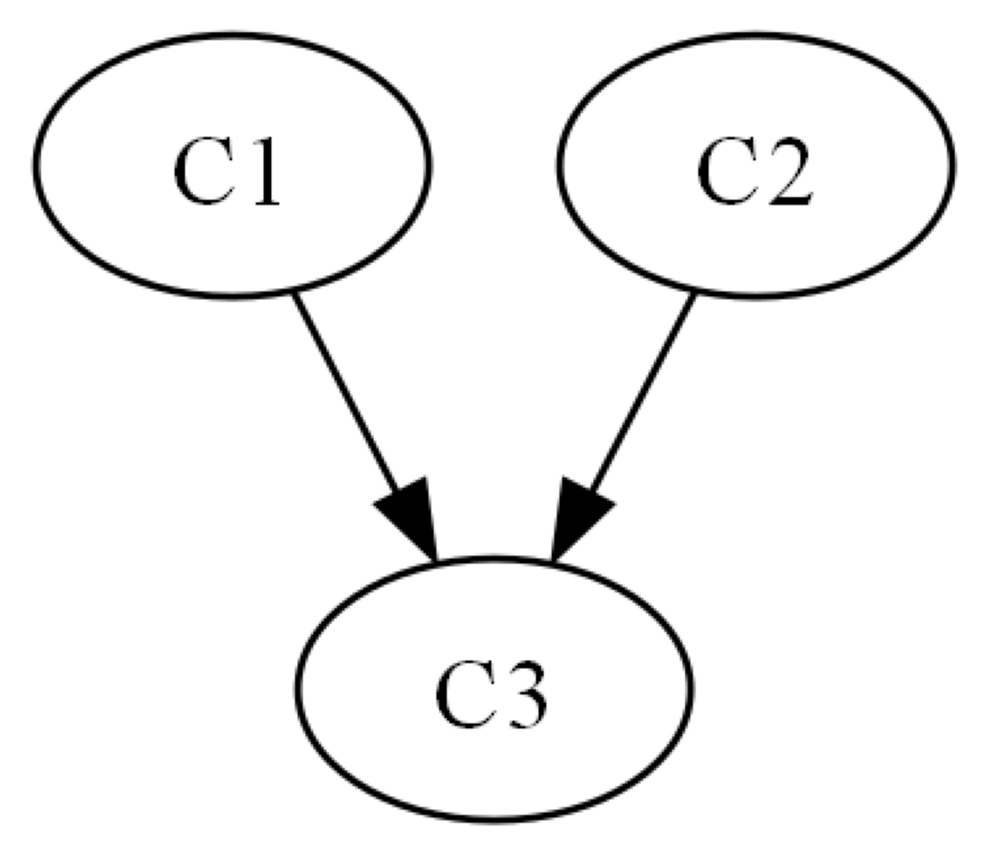

In [34]:
# Draw C-DAG
cluster_dag.cluster_graph.draw_pydot_graph()

Next the causal graph associated to the C-DAG has to be initalized, edges have to be pruned and oriented. cluster_dag.cdag_to_mpdag handles this and then cluster_dag.cg becomes available. This object is the supergraph of all DAGs compatible with the C-DAG. It has directed edges between members of $C_1$ and $C_2$ and undirected edges within clusters. 

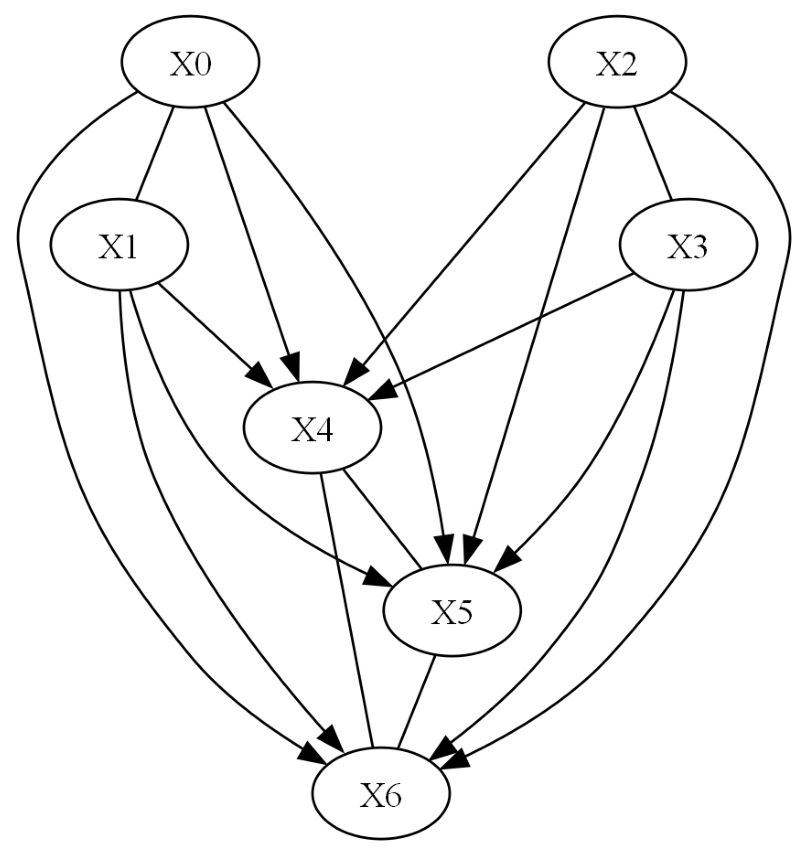

In [35]:
cluster_dag.cdag_to_mpdag()
cluster_dag.cg.draw_pydot_graph()

Lastly, the true dag is added to cluster_dag. 

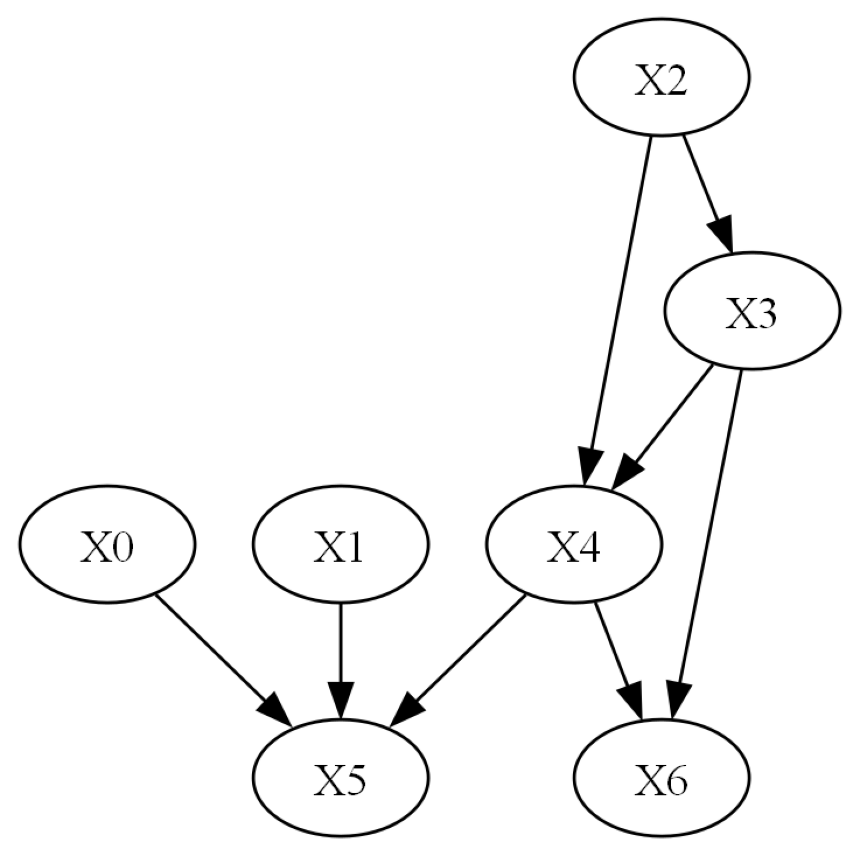

In [36]:
cluster_dag.true_dag = cg
cluster_dag.true_dag.draw_pydot_graph()

Next generate gaussian data for C-PC and PC with Utils.py gaussian_data(). This is an additive noise model with weights 1.0. 

In [37]:
data = gaussian_data(W = W, sample_size = 1000, seed = 100)
data.shape

(1000, 7)

To run PC use the causallearn package. 

In [38]:
pc_est_graph = pc(data, alpha = 0.1, verbose=False, node_names=node_names)

Depth=2, working on node 6: 100%|██████████| 7/7 [00:00<00:00, 778.18it/s] 


pc_est_graph is a CausalGraph object and can be drawn

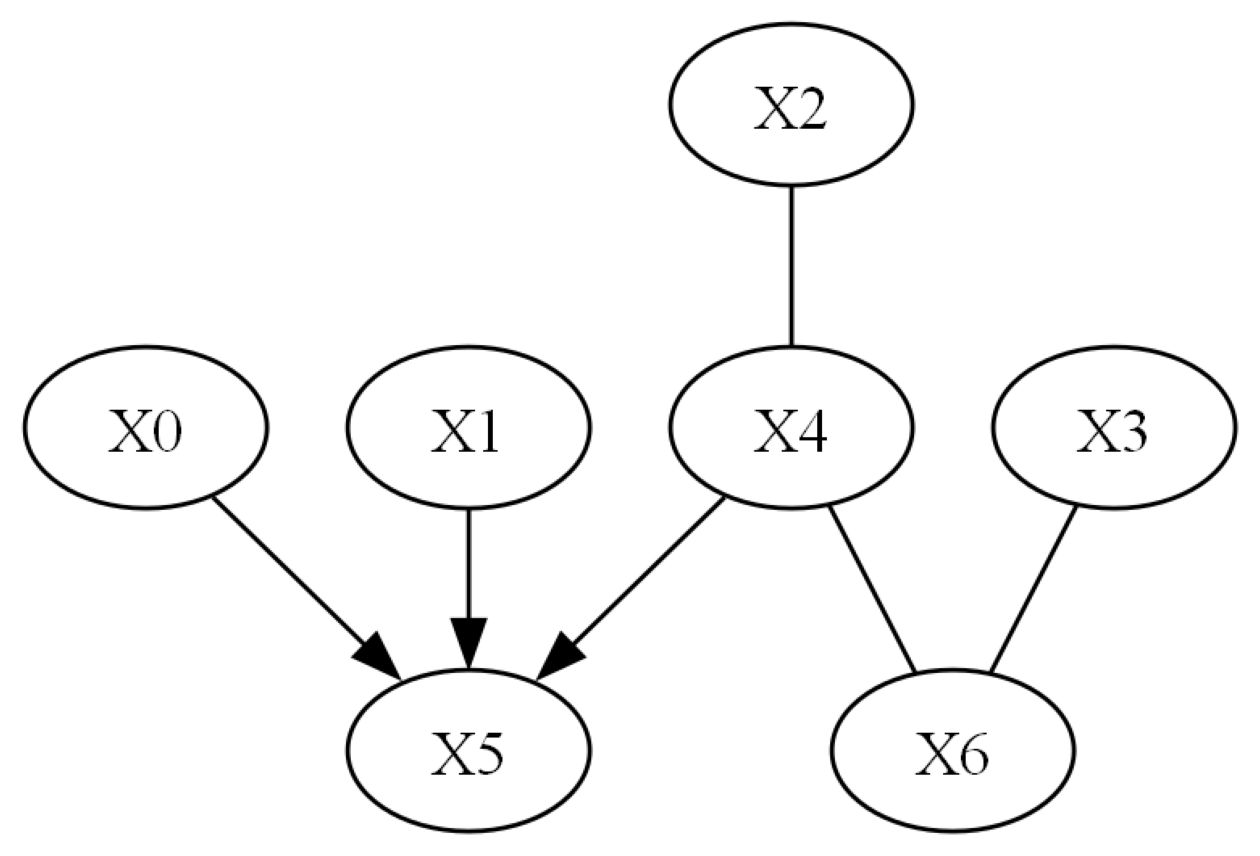

In [39]:
pc_est_graph.draw_pydot_graph()

To run C-PC initialize a cluster_pc object and use the cluster_pc.run() function. 

In [40]:
cluster_pc = ClusterPC(cdag = cluster_dag, data = data, alpha = 0.1, 
                  indep_test = "fisherz", \
                  verbose = False, show_progress=True)
cluster_pc_est_graph = cluster_pc.run()

C3 phase, Depth=2, working on node 6: 100%|██████████| 3/3 [00:00<00:00, 427.84it/s, duration: 0.04sec]

Duration of algorithm was 0.05sec


cluster_est_graph is a CausalGraph object and can be drawn. 

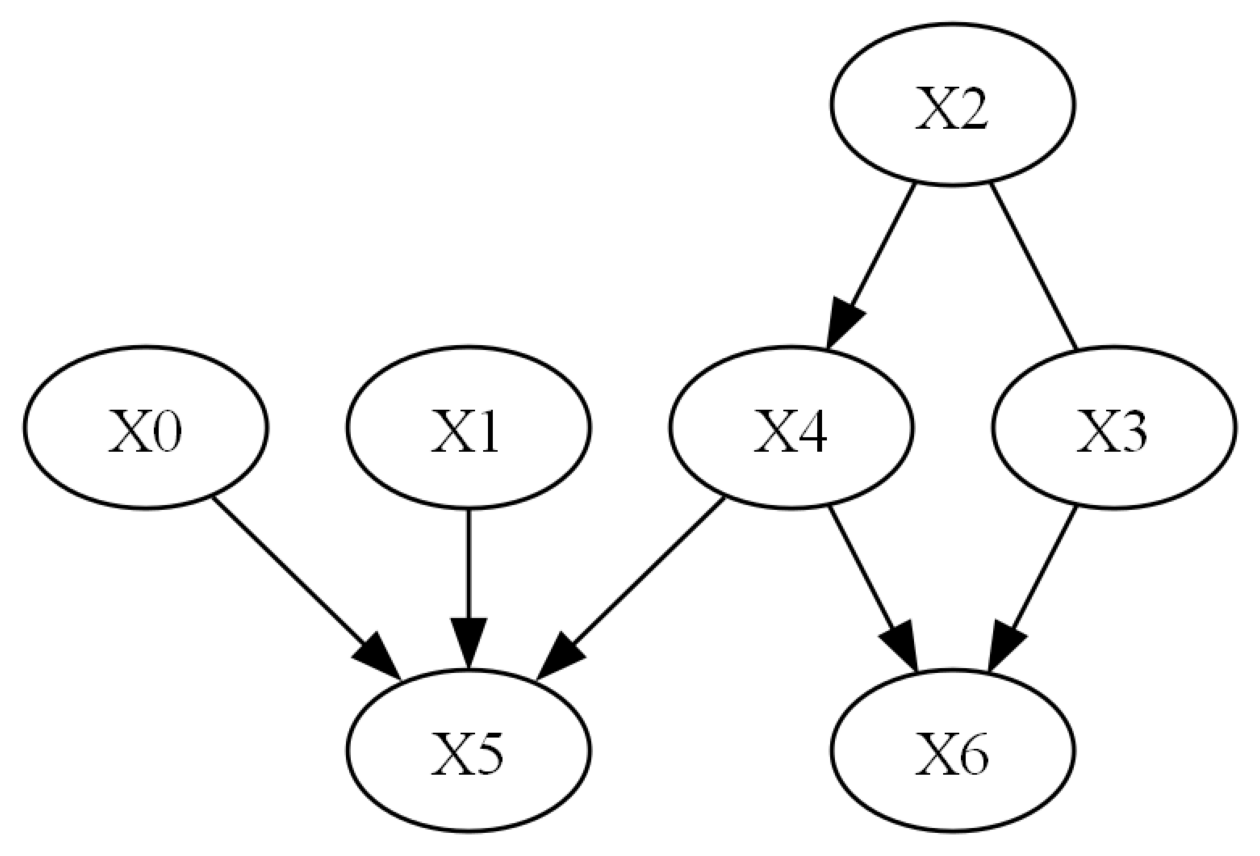

In [41]:
cluster_pc_est_graph.draw_pydot_graph()

For more evaluations one can call the Evaluator class from clustercausal. The adjacency confusion counts how many edges are correct. Arrow confusion counts how many arrows are correct. SHD is the structural hamming distance and SID is the structural intervention distance. SID can be calculated but takes around 5 seconds, can be turned off by changing to get_causallearn_metrics(sid = False). 

In [42]:
# Evaluator works on the GeneralGraph object of a CausalGraph object, which is cg.G, cluster_dag.true_dag.G or pc_est_graph.G
eval_pc = Evaluator(truth = cluster_dag.true_dag.G, est = pc_est_graph.G)
adjacency_confusion, arrow_confusion, shd, sid = eval_pc.get_causallearn_metrics(sid = True)
print("Adjacency confusion: ", adjacency_confusion)
print("Arrow confusion: ", arrow_confusion)
print("SHD: ", shd)
print("SID: ",  sid)

Adjacency confusion:  {'true_positive': 6, 'false_positive': 0, 'false_negative': 2, 'true_negative': 13, 'precision': 1.0, 'recall': 0.75, 'f1_score': 0.8571428571428571}
Arrow confusion:  {'true_positive': 3.0, 'false_positive': 0.0, 'false_negative': 5.0, 'true_negative': 41.0, 'precision': 1.0, 'recall': 0.375, 'f1_score': 0.5454545454545454, 'true_positive_ce': 3.0, 'false_positive_ce': 0.0, 'false_negative_ce': 3.0, 'true_negative_ce': 43.0, 'precision_ce': 1.0, 'recall_ce': 0.5, 'f1_score_ce': 0.6666666666666666}
SHD:  2
SID:  {'sid_lower': 8, 'sid_upper': 15}


In [43]:
eval_cluster_pc = Evaluator(truth = cluster_dag.true_dag.G, est = cluster_pc_est_graph.G)
adjacency_confusion, arrow_confusion, shd, sid = eval_cluster_pc.get_causallearn_metrics(sid = True)
print("Adjacency confusion: ", adjacency_confusion)
print("Arrow confusion: ", arrow_confusion)
print("SHD: ", shd)
print("SID: ",  sid)

Adjacency confusion:  {'true_positive': 7, 'false_positive': 0, 'false_negative': 1, 'true_negative': 13, 'precision': 1.0, 'recall': 0.875, 'f1_score': 0.9333333333333333}
Arrow confusion:  {'true_positive': 6.0, 'false_positive': 0.0, 'false_negative': 2.0, 'true_negative': 41.0, 'precision': 1.0, 'recall': 0.75, 'f1_score': 0.8571428571428571, 'true_positive_ce': 6.0, 'false_positive_ce': 0.0, 'false_negative_ce': 1.0, 'true_negative_ce': 42.0, 'precision_ce': 1.0, 'recall_ce': 0.8571428571428571, 'f1_score_ce': 0.923076923076923}
SHD:  1
SID:  {'sid_lower': 2, 'sid_upper': 10}


As the evaluation shows, the algorithms don't recover the correct skeleton due to false CI tests. PC erroneously removes the edges between $X_2, X_3$ and $X_3, X_4$. C-PC only erroneously removes the edge $X_3, X_4$. To investigate what happened, one can set verbose = True to see what the algorithms did. 

Ctrl+f searching for '2 ind 3' and '3 ind 2' reveals that PC found $X_2 \perp\!\!\!\perp X_3 \mid X_4$ with p-value 0.48 and $X_2 \perp\!\!\!\perp X_3 \mid X_6$ with p-value 0.61. Furthermore searching for '3 ind 4' and '4 ind 3' reveals that PC found $X_3 \perp\!\!\!\perp X_4 \mid X_6$ with p-value 0.2. 

After the analysis collapse the output, which is very long, by double clicking on the left of the output panel. 

Ctrl+f searching '2 ind 3' and '3 ind 2' reveals that C-PC does not perfrom CI tests $X_2 \perp\!\!\!\perp X_3 \mid X_4$  and $X_2 \perp\!\!\!\perp X_3 \mid X_6$ because $X_4, X_6$ are not in the local graph of $C_2$, which is $L_2 = C_2 \cup \bigcup_{C_s \in pa_{C_2}^{G_C}} C_s = C_2$. So the edge between $X_2$ and $X_3$ stays in the graph.

Searching for '3 ind 4' and '4 ind 3' shows that C-PC also finds $X_3 \perp\!\!\!\perp X_4 \mid X_6$ with p-value 0.2, so that edge is deleted in C-PC, too. 

Due to the added C-DAG structure, C-PC is able to avoid the false CI tests and perform better. 

In [44]:
pc_est_graph = pc(data, alpha = 0.1, verbose=True, node_names=node_names)

Depth=2, working on node 6: 100%|██████████| 7/7 [00:00<00:00, 1000.79it/s]

0 ind 1 | () with p-value 0.599224

0 ind 2 | () with p-value 0.331663

0 ind 3 | () with p-value 0.497059

0 ind 4 | () with p-value 0.853097

0 dep 5 | () with p-value 0.000000

0 ind 6 | () with p-value 0.785104

1 ind 0 | () with p-value 0.599224

1 ind 2 | () with p-value 0.819113

1 ind 3 | () with p-value 0.463628

1 ind 4 | () with p-value 0.475095

1 dep 5 | () with p-value 0.000000

1 ind 6 | () with p-value 0.517298

2 ind 0 | () with p-value 0.331663

2 ind 1 | () with p-value 0.819113

2 dep 3 | () with p-value 0.000000

2 dep 4 | () with p-value 0.000000

2 dep 5 | () with p-value 0.000000

2 dep 6 | () with p-value 0.000000

3 ind 0 | () with p-value 0.497059

3 ind 1 | () with p-value 0.463628

3 dep 2 | () with p-value 0.000000

3 dep 4 | () with p-value 0.000000

3 dep 5 | () with p-value 0.000000

3 dep 6 | () with p-value 0.000000

4 ind 0 | () with p-value 0.853097

4 ind 1 | () with p-value 0.475095

4 dep 2 | () with p-value 0.000000

4 dep 3 | () with p-value 0.

In [45]:
cluster_pc = ClusterPC(cdag = cluster_dag, data = data, alpha = 0.1, 
                  indep_test = "fisherz", \
                  verbose = True, show_progress=True)
cluster_pc_est_graph = cluster_pc.run()

Topological ordering ['C1', 'C2', 'C3']
Cluster node indices of C1 are [0 1]
Local graph node indices of C1 are [0 1]


C1 phase, Depth=0, working on node 1: 100%|██████████| 2/2 [00:00<00:00, 500.36it/s, duration: 0.00sec]


Depth is 0
Nonchilds of 0 are [1]
Testing edges from 0 to 1
0 ind 1 | () with p-value 0.599224
Nonchilds of 1 are [0]
Testing edges from 1 to 0
1 ind 0 | () with p-value 0.599224
Deleted edge from X0 to X1
Cluster node indices of C2 are [2 3]
Local graph node indices of C2 are [2 3]


C2 phase, Depth=0, working on node 3: 100%|██████████| 2/2 [00:00<00:00, 400.39it/s, duration: 0.01sec]


Depth is 0
Nonchilds of 2 are [3]
Testing edges from 2 to 3
2 dep 3 | () with p-value 0.000000
Nonchilds of 3 are [2]
Testing edges from 3 to 2
3 dep 2 | () with p-value 0.000000
Cluster node indices of C3 are [4 5 6]
Local graph node indices of C3 are [0 1 2 3 4 5 6]


C3 phase, Depth=2, working on node 6: 100%|██████████| 3/3 [00:00<00:00, 376.20it/s, duration: 0.04sec]

Depth is 0
Nonchilds of 4 are [0 1 2 3 5 6]
Testing edges from 4 to 0
4 ind 0 | () with p-value 0.853097
Testing edges from 4 to 1
4 ind 1 | () with p-value 0.475095
Testing edges from 4 to 2
4 dep 2 | () with p-value 0.000000
Testing edges from 4 to 3
4 dep 3 | () with p-value 0.000000
Testing edges from 4 to 5
4 dep 5 | () with p-value 0.000000
Testing edges from 4 to 6
4 dep 6 | () with p-value 0.000000
Nonchilds of 5 are [0 1 2 3 4 6]
Testing edges from 5 to 0
5 dep 0 | () with p-value 0.000000
Testing edges from 5 to 1
5 dep 1 | () with p-value 0.000000
Testing edges from 5 to 2
5 dep 2 | () with p-value 0.000000
Testing edges from 5 to 3
5 dep 3 | () with p-value 0.000000
Testing edges from 5 to 4
5 dep 4 | () with p-value 0.000000
Testing edges from 5 to 6
5 dep 6 | () with p-value 0.000000
Nonchilds of 6 are [0 1 2 3 4 5]
Testing edges from 6 to 0
6 ind 0 | () with p-value 0.785104
Testing edges from 6 to 1
6 ind 1 | () with p-value 0.517298
Testing edges from 6 to 2
6 dep 2 | 

One can also compare the numer of CI tests the two methods perform comparing the 3 cluster C-PC with a 1 cluster C-PC, which is equivalent to PC. 

In [46]:
no_clust_cluster_mapping = {'C1': ['X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6']}
no_clust_cluster_edges = []
no_clust_cluster_dag = ClusterDAG(cluster_mapping=no_clust_cluster_mapping, cluster_edges=no_clust_cluster_edges)

In [47]:
no_clust_cpc = ClusterPC(cdag = no_clust_cluster_dag, data = data, alpha = 0.1, \
                    indep_test = "fisherz", verbose = False, show_progress=True, cluster_only=True)
no_clust_cpc_est_graph = no_clust_cpc.run()

C1 phase, Depth=2, working on node 6: 100%|██████████| 7/7 [00:00<00:00, 701.86it/s, duration: 0.05sec]

Duration of algorithm was 0.05sec


In [48]:
print(f' Without clustering: {no_clust_cpc.no_of_indep_tests_performed} CI tests, \n with 3 clusters: {cluster_pc.no_of_indep_tests_performed} CI tests')

 Without clustering: 126 CI tests, 
 with 3 clusters: 82 CI tests


The number of CI tests when going to C-PC was reduced by around 37%. 

## Example 4: 10-node graph with 1 cluster
This example shows how C-PC is the same as PC when every node is in the same cluster. This is a sanity check to make sure that C-PC works as intended, this case is also a test_case in the test_cluster_pc.py file and is also sanity checked in the simulation studies. 

In [49]:
# Construct DAG as CausalGraph object and get adjacency matrix with make_graph() function from Utils.py
node_names = ['X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9']
parent_dict = {'X0': [], 'X1': ['X0'], 'X2': ['X0'], 'X3': ['X2', 'X1'], 'X4': ['X2'], 'X5' : ['X0', 'X3', 'X4'], 'X6': ['X2', 'X5'], 'X7': ['X8'], 'X8': ['X6'], 'X9': ['X6']}
cg, W = make_graph(node_names, parent_dict)

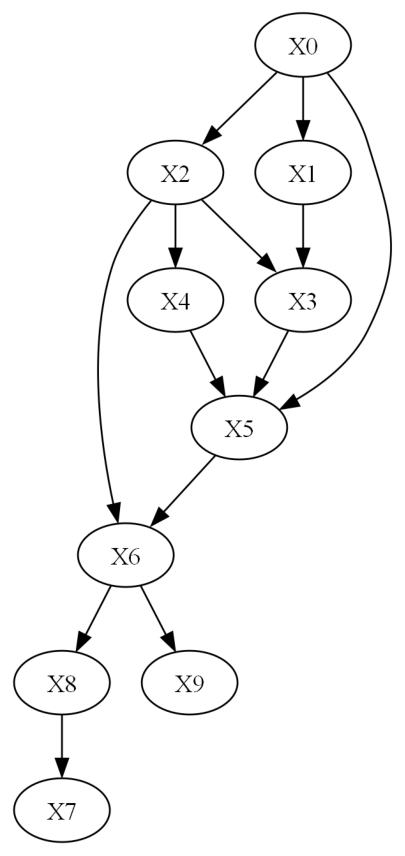

In [50]:
# Draw DAG
cg.draw_pydot_graph()

Next construct ClusterDAG object with C-DAG. 

In [51]:
cluster_mapping = {'C1': ['X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9']}
cluster_edges = []
cluster_dag = ClusterDAG(cluster_mapping=cluster_mapping, cluster_edges=cluster_edges)
print(f'Cluster mapping: {cluster_dag.cluster_mapping} \n Cluster edges: {cluster_dag.cluster_edges}')

Cluster mapping: {'C1': ['X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9']} 
 Cluster edges: []


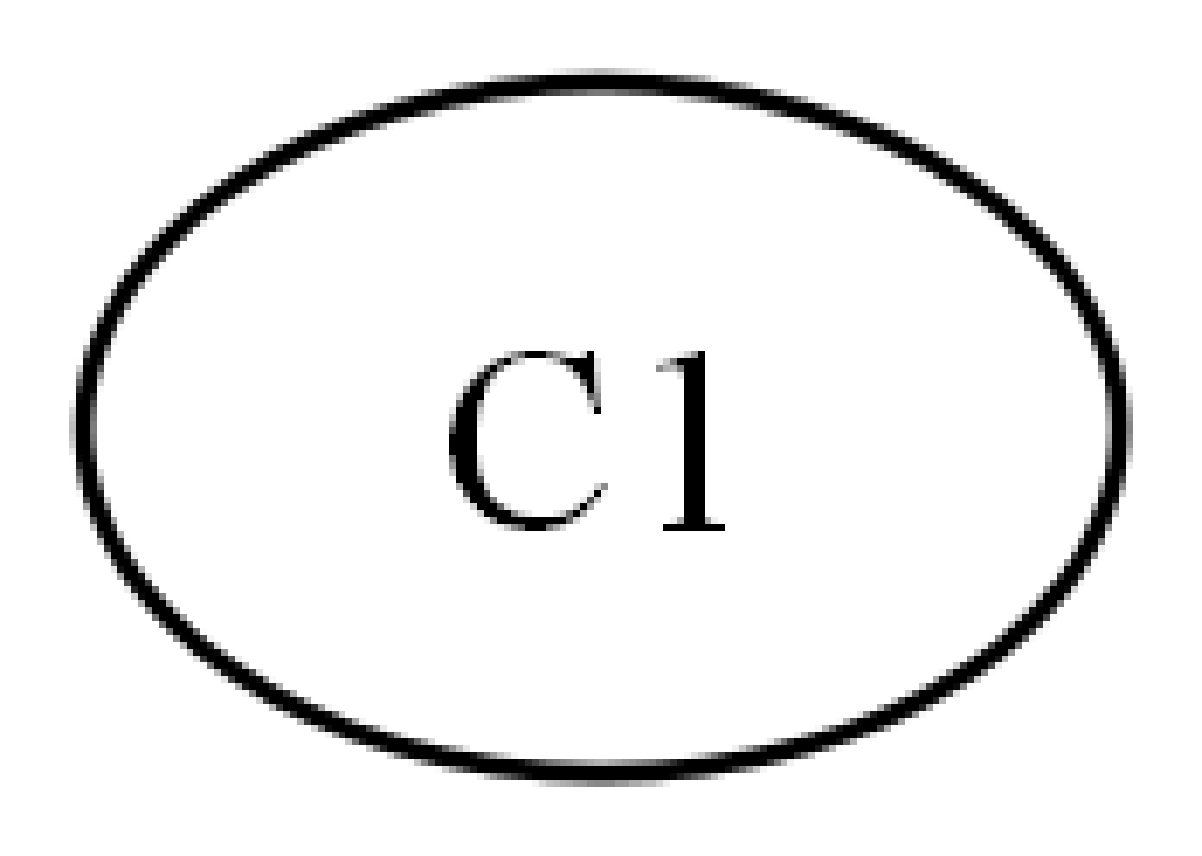

In [52]:
# Draw C-DAG
cluster_dag.cluster_graph.draw_pydot_graph()

Next the causal graph associated to the C-DAG has to be initalized, edges have to be pruned and oriented. cluster_dag.cdag_to_mpdag handles this and then cluster_dag.cg becomes available. This object is the supergraph of all DAGs compatible with the C-DAG. It has directed edges between members of $C_1$ and $C_2$ and undirected edges within clusters. 

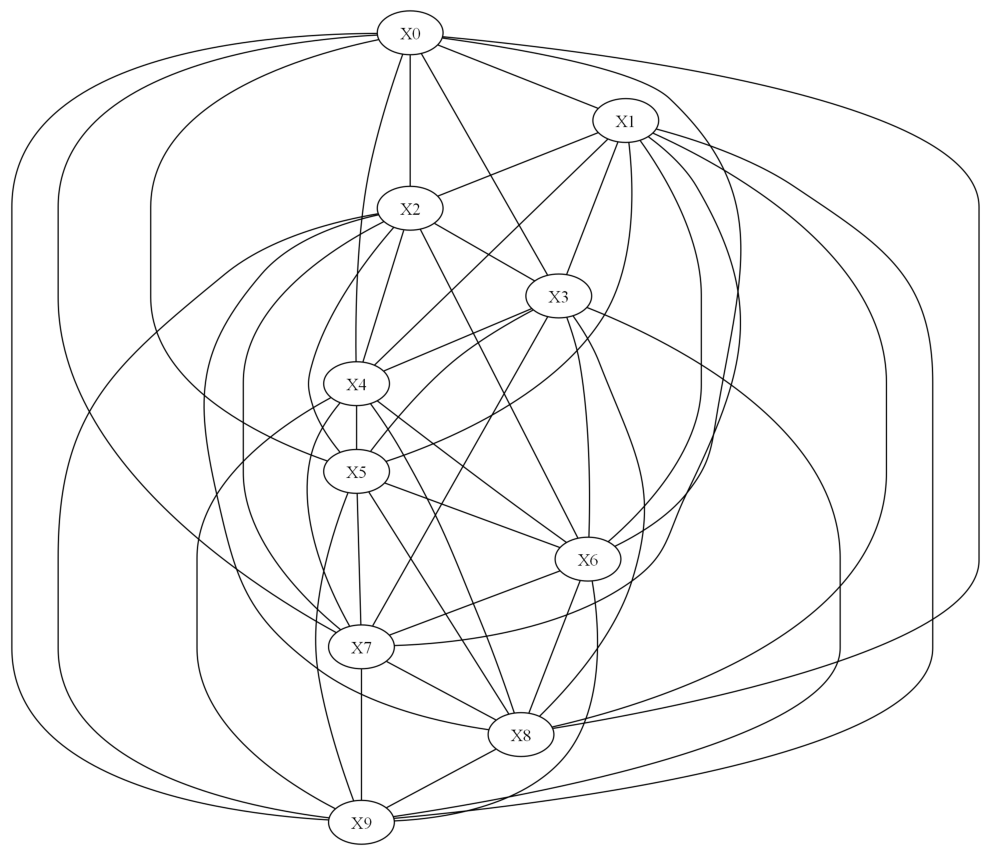

In [53]:
cluster_dag.cdag_to_mpdag()
cluster_dag.cg.draw_pydot_graph()

Lastly, the true dag is added to cluster_dag. 

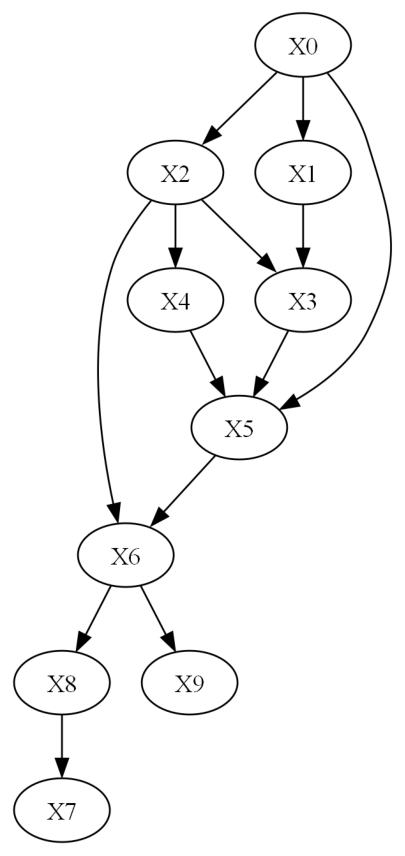

In [54]:
cluster_dag.true_dag = cg
cluster_dag.true_dag.draw_pydot_graph()

Next generate gaussian data for C-PC and PC with Utils.py gaussian_data(). This is an additive noise model with weights 1.0. 

In [55]:
data = gaussian_data(W = W, sample_size = 1000, seed = 42)
data.shape

(1000, 10)

To run PC use the causallearn package. 

In [56]:
pc_est_graph = pc(data, alpha = 0.1, verbose=False, node_names=node_names)

Depth=3, working on node 9: 100%|██████████| 10/10 [00:00<00:00, 667.09it/s]


pc_est_graph is a CausalGraph object and can be drawn

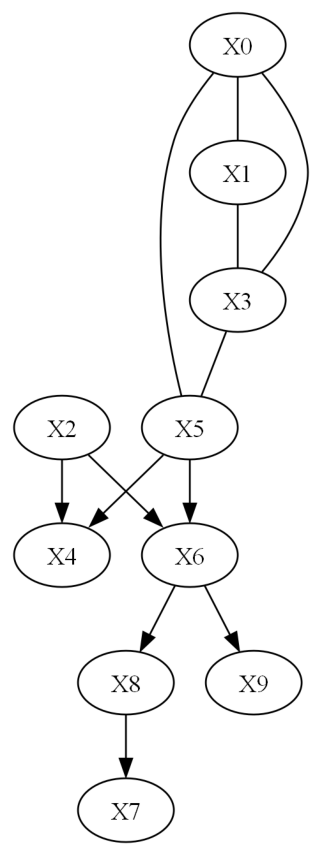

In [57]:
pc_est_graph.draw_pydot_graph()

To run C-PC initialize a cluster_pc object and use the cluster_pc.run() function. 

In [58]:
cluster_pc = ClusterPC(cdag = cluster_dag, data = data, alpha = 0.1, 
                  indep_test = "fisherz", \
                  verbose = False, show_progress=True)
cluster_pc_est_graph = cluster_pc.run()

C1 phase, Depth=3, working on node 9: 100%|██████████| 10/10 [00:00<00:00, 555.89it/s, duration: 0.30sec]

Duration of algorithm was 0.31sec


cluster_est_graph is a CausalGraph object and can be drawn. 

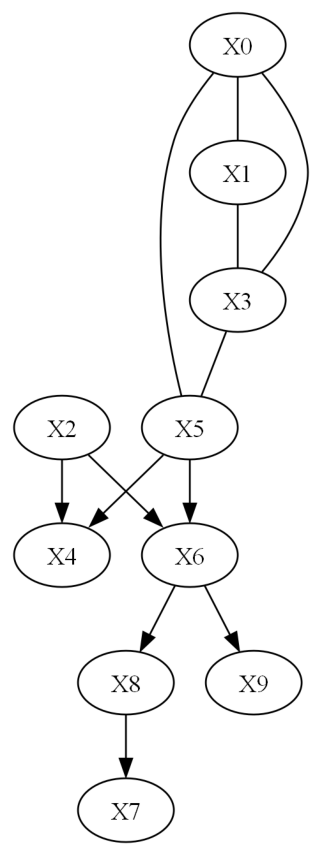

In [59]:
cluster_pc_est_graph.draw_pydot_graph()

For more evaluations one can call the Evaluator class from clustercausal. SID can be calculated but takes around 5 seconds, can be turned off by changing to get_causallearn_metrics(sid = False). 

The adjacency confusion counts how many edges are correct. Arrow confusion counts how many arrows are correct. SHD is the structural hamming distance and SID is the structural intervention distance.

In [60]:
# Evaluator works on the GeneralGraph object of a CausalGraph object, which is cg.G, cluster_dag.true_dag.G or pc_est_graph.G
eval_pc = Evaluator(truth = cluster_dag.true_dag.G, est = pc_est_graph.G)
adjacency_confusion, arrow_confusion, shd, sid = eval_pc.get_causallearn_metrics(sid = True)
print("Adjacency confusion: ", adjacency_confusion)
print("Arrow confusion: ", arrow_confusion)
print("SHD: ", shd)
print("SID: ",  sid)

Adjacency confusion:  {'true_positive': 11, 'false_positive': 1, 'false_negative': 2, 'true_negative': 31, 'precision': 0.9166666666666666, 'recall': 0.8461538461538461, 'f1_score': 0.8799999999999999}
Arrow confusion:  {'true_positive': 6.0, 'false_positive': 1.0, 'false_negative': 7.0, 'true_negative': 86.0, 'precision': 0.8571428571428571, 'recall': 0.46153846153846156, 'f1_score': 0.6, 'true_positive_ce': 6.0, 'false_positive_ce': 1.0, 'false_negative_ce': 5.0, 'true_negative_ce': 88.0, 'precision_ce': 0.8571428571428571, 'recall_ce': 0.5454545454545454, 'f1_score_ce': 0.6666666666666665}
SHD:  4
SID:  {'sid_lower': 30, 'sid_upper': 51}


In [61]:
eval_cluster_pc = Evaluator(truth = cluster_dag.true_dag.G, est = cluster_pc_est_graph.G)
adjacency_confusion, arrow_confusion, shd, sid = eval_cluster_pc.get_causallearn_metrics(sid = True)
print("Adjacency confusion: ", adjacency_confusion)
print("Arrow confusion: ", arrow_confusion)
print("SHD: ", shd)
print("SID: ",  sid)

Adjacency confusion:  {'true_positive': 11, 'false_positive': 1, 'false_negative': 2, 'true_negative': 31, 'precision': 0.9166666666666666, 'recall': 0.8461538461538461, 'f1_score': 0.8799999999999999}
Arrow confusion:  {'true_positive': 6.0, 'false_positive': 1.0, 'false_negative': 7.0, 'true_negative': 86.0, 'precision': 0.8571428571428571, 'recall': 0.46153846153846156, 'f1_score': 0.6, 'true_positive_ce': 6.0, 'false_positive_ce': 1.0, 'false_negative_ce': 5.0, 'true_negative_ce': 88.0, 'precision_ce': 0.8571428571428571, 'recall_ce': 0.5454545454545454, 'f1_score_ce': 0.6666666666666665}
SHD:  4
SID:  {'sid_lower': 30, 'sid_upper': 51}


As can be seen, PC and C-PC retrieve the exact same graph. 

## Example 5: Generating a DAG and data with the simulation toolbox

This last example shows how one can use the Simulator to generate a DAG and data and then run C-PC and PC on it.

In [62]:
simulation = Simulator(n_nodes = 6, n_edges = 10, dag_method = 'erdos_renyi', 
                       n_clusters = 3, weight_range = (-1,2), 
                       distribution_type = 'gauss', seed = 42, sample_size = 1000)
cluster_dag = simulation.run()

2023-11-25 15:02:16,374 - c:\Users\JanMarco\MLProjects\Masterthesis\masterthesis\mthesis\lib\site-packages\castle\datasets\simulator.py[line:270] - INFO: Finished synthetic dataset


In [63]:
cluster_dag.cluster_mapping

{'C1': ['X5', 'X3'], 'C2': ['X6', 'X1', 'X2'], 'C3': ['X4']}

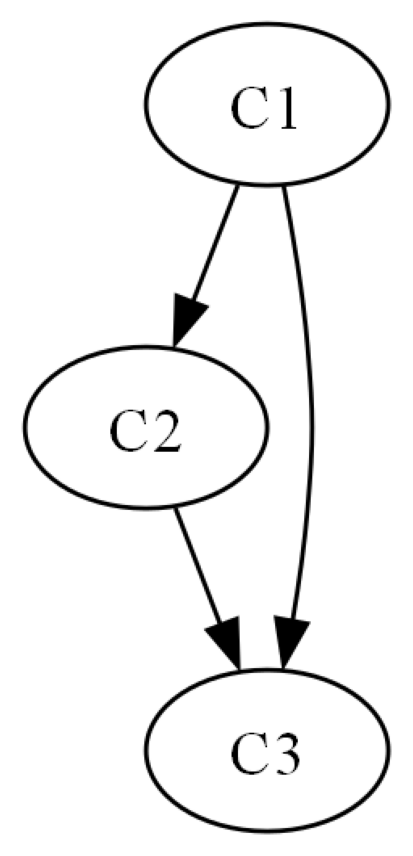

In [64]:
cluster_dag.draw_cluster_graph()

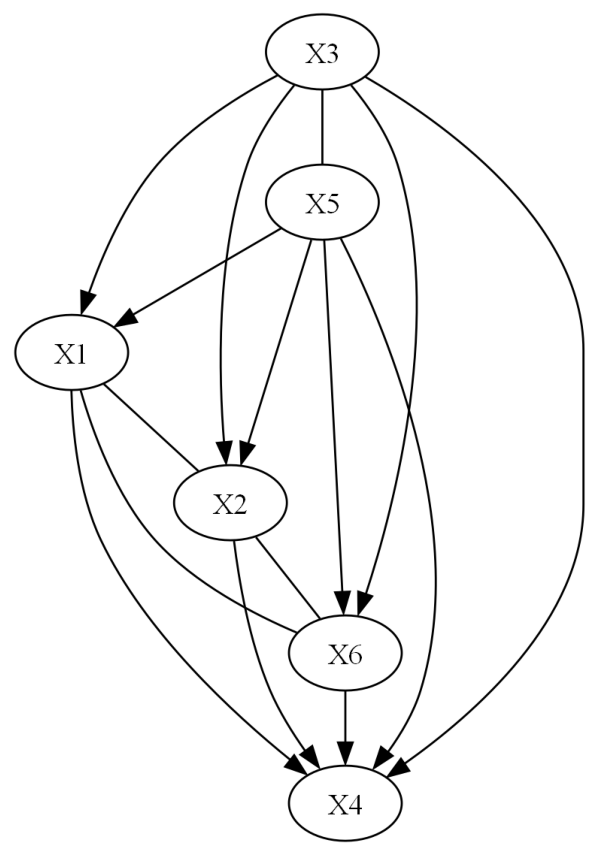

In [65]:
cluster_dag.cdag_to_mpdag()
cluster_dag.cg.draw_pydot_graph()

In [66]:
cluster_pc = ClusterPC(cdag = cluster_dag, data = cluster_dag.data, alpha = 0.05, \
                  indep_test = "fisherz", \
                  verbose = False, show_progress=True)
cluster_pc_est_graph = cluster_pc.run()

C3 phase, Depth=3, working on node 3: 100%|██████████| 1/1 [00:00<00:00, 125.09it/s, duration: 0.06sec]

Duration of algorithm was 0.16sec


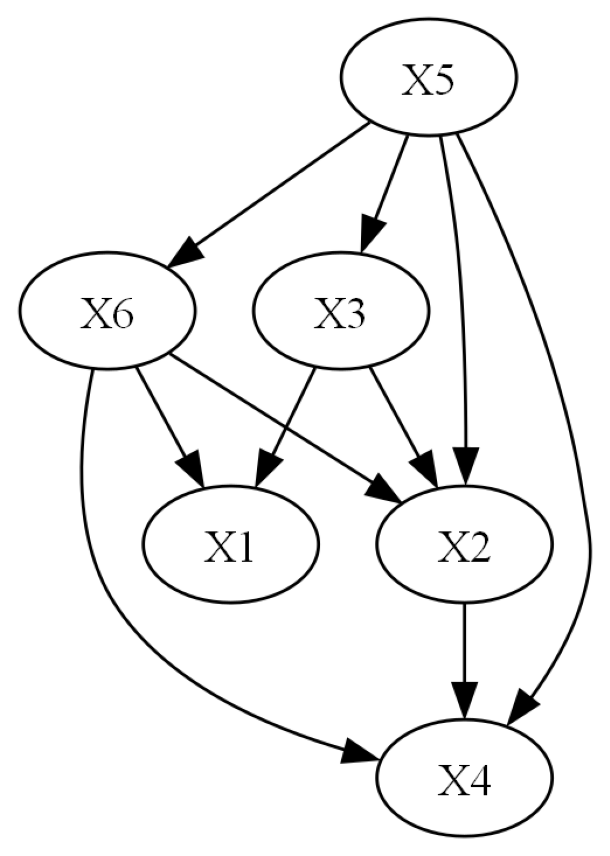

In [67]:
cluster_dag.true_dag.draw_pydot_graph()

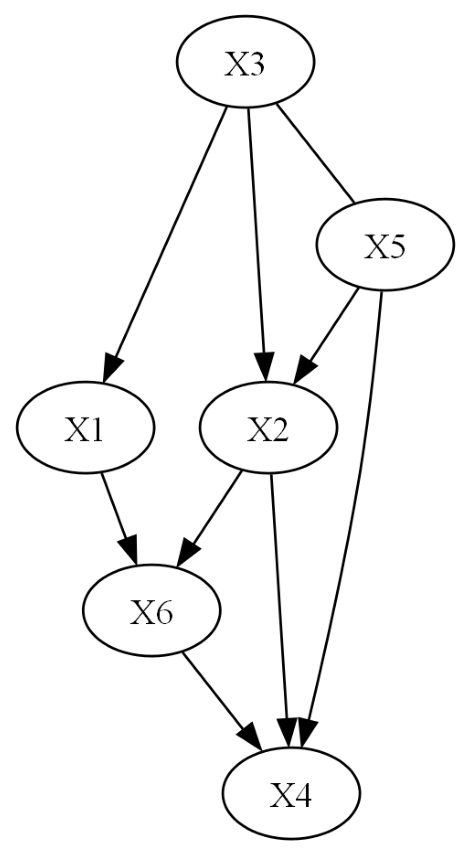

In [68]:
cluster_pc_est_graph.draw_pydot_graph()

In [69]:
eval_cluster_pc = Evaluator(truth = cluster_dag.true_dag.G, est = cluster_pc_est_graph.G)
adjacency_confusion, arrow_confusion, shd, sid = eval_cluster_pc.get_causallearn_metrics(sid = True)
print("Adjacency confusion: ", adjacency_confusion)
print("Arrow confusion: ", arrow_confusion)
print("SHD: ", shd)
print("SID: ",  sid)

Adjacency confusion:  {'true_positive': 9, 'false_positive': 0, 'false_negative': 1, 'true_negative': 5, 'precision': 1.0, 'recall': 0.9, 'f1_score': 0.9473684210526316}
Arrow confusion:  {'true_positive': 6.0, 'false_positive': 2.0, 'false_negative': 4.0, 'true_negative': 24.0, 'precision': 0.75, 'recall': 0.6, 'f1_score': 0.6666666666666665, 'true_positive_ce': 6.0, 'false_positive_ce': 2.0, 'false_negative_ce': 3.0, 'true_negative_ce': 25.0, 'precision_ce': 0.75, 'recall_ce': 0.6666666666666666, 'f1_score_ce': 0.7058823529411765}
SHD:  3
SID:  {'sid_lower': 12, 'sid_upper': 21}
